In [336]:
import json
import glob
import ast
import gzip
import os
import yaml
from tqdm import tqdm
import re
from collections import defaultdict


import lightgbm as lgb
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import math
import warnings
import pickle
import time
import lightgbm as lgm
import datetime
import ast
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K


from datetime import date, time
from lightgbm import LGBMClassifier, LGBMRegressor
from pandas.plotting import scatter_matrix
from scipy import interp
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.sparse import csr_matrix, hstack

#MODELS
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2 
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, log_loss, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from statsmodels.graphics.gofplots import qqplot

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

%matplotlib inline
warnings.filterwarnings('ignore')

%matplotlib inline

In [211]:
df = pd.read_csv("scaled_filtered_24_4_10.csv", nrows = 1000
                )

In [212]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df)

,Unnamed: 0,combat_id,start_time,number_of_rounds,player_ids,player_info,monsters_info,party_size,total_slots,total_max_slots,party_classes_with_level,party_total_class_composition,player_individual_hp_ratios,player_individual_ac,player_individual_prof_bonus,player_individual_strength,player_individual_dexterity,player_individual_constitution,player_individual_intelligence,player_individual_wisdom,player_individual_charisma,monster_types,monster_number,monster_total_level,party_total_level,party_level1_spellslots,party_level2_spellslots,party_level3_spellslots,party_level4_spellslots,party_level5_spellslots,party_level6_spellslots,party_level7_spellslots,party_level8_spellslots,party_level9_spellslots,party_total_ac,party_total_precombat_hp,party_total_postcombat_hp,party_total_hpratio,party_total_prof_bonus,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,party_total_charisma,player_monster_ratio,monster_player_ratio,party_max_hp,Blood Hunter,Wizard,Fighter,Paladin,Bard,Cleric,Warlock,Ranger,Barbarian,Druid,Monk,Sorcerer,Rogue,weighted_monster_level,weighted_spell_slots
0,1,1653817902-15ec25a2-6757-4ceb-ac41-d44352b97705,1653817902.74,1,['209330647903743785'],"[{'hp_ratio': (65, 65), 'class': [('Ranger', 1...",[{'monster_id': 'c0cdb522-64c2-42ee-b1a8-6ef22...,1,"{'1': 4, '2': 3, '3': 2, '4': 0, '5': 0, '6': ...","{'1': 4, '2': 3, '3': 2, '4': 0, '5': 0, '6': ...","[('Ranger', 10)]",['Ranger'],"[(65, 65)]",[17],[4],[14],[16],[12],[12],[14],[11],['Warrior (level 4)'],1,4.00,10,4,3,2,0,0,0,0,0,0,17,65,65,1.00,4,14,16,12,12,14,11,1.00,1.00,65,0,0,0,0,0,0,0,1,0,0,0,0,0,4.00,139
1,14,1653869871-e7fd0606-de62-4688-a55b-ae4c25a14beb,1653869871.84,2,['176588704091156599'],"[{'hp_ratio': (0, 38), 'class': [('Monk', 4), ...",[{'monster_id': '3bdb4cc1-6ca9-47e8-9610-d68ef...,1,"{'1': 2, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","{'1': 2, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","[('Monk', 4), ('Cleric', 1)]","['Monk', 'Cleric']","[(0, 38)]",[14],[3],[14],[16],[14],[10],[13],[13],"['Flying Sword', 'Flying Sword', 'Black Dragon...",3,2.50,5,2,0,0,0,0,0,0,0,0,14,38,0,0.00,3,14,16,14,10,13,13,0.33,3.00,38,0,0,0,0,0,1,0,0,0,0,1,0,0,5.00,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,2501,1656164288-ca976d7b-46c8-41f8-87fd-941e98f4f480,1656164288.95,4,['321444462285149813'],"[{'hp_ratio': (93, 93), 'class': [('Rogue', 8)...",[{'monster_id': '2f943457-2c0c-4ec6-bdae-94b20...,1,"{'1': 1, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","{'1': 1, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","[('Rogue', 8), ('Fighter', 6)]","['Rogue', 'Fighter']","[(93, 93)]",[17],[5],[13],[19],[13],[8],[13],[15],['Devourer'],1,13.00,14,1,0,0,0,0,0,0,0,0,17,93,93,1.00,5,13,19,13,8,13,15,1.00,1.00,93,0,0,1,0,0,0,0,0,0,0,0,0,1,13.00,6
999,2502,1656164636-fe43bf4e-136c-480f-a246-df9aaebf9435,1656164636.27,6,"['159332117133051198', '326793710699339197', '...","[{'hp_ratio': (131, 191), 'class': [('Druid', ...",[{'monster_id': 'b60669e9-c580-4965-a850-fdbc3...,5,"{'1': 13, '2': 9, '3': 9, '4': 9, '5': 7, '6':...","{'1': 14, '2': 9, '3': 9, '4': 9, '5': 7, '6':...","[('Druid', 17), ('Fighter', 17), ('Rogue', 8),...","['Druid', 'Fighter', 'Rogue', 'Fighter', 'Sorc...","[(131, 191), (129, 175), (92, 175), (123, 158)...","[23, 18, 24, 24, 18]","[6, 6, 6, 6, 6]","[11, 13, 12, 8, 13]","[12, 20, 20, 14, 16]","[19, 14, 16, 16, 20]","[9, 10, 12, 12, 22]","[20, 20, 15, 12, 13]","[14, 8, 10, 20, 8]",['Dracohydra'],1,11.00,91,13,9,9,9,7,2,4,3,1,107,776,620,0.80,30,57,82,85,65,80,60,5.00,0.20,881,0,1,1,0,0,0,1,0,0,1,0,1,1,11.00,2256


In [213]:
df.columns

Index(['Unnamed: 0', 'combat_id', 'start_time', 'number_of_rounds',
       'player_ids', 'player_info', 'monsters_info', 'party_size',
       'total_slots', 'total_max_slots', 'party_classes_with_level',
       'party_total_class_composition', 'player_individual_hp_ratios',
       'player_individual_ac', 'player_individual_prof_bonus',
       'player_individual_strength', 'player_individual_dexterity',
       'player_individual_constitution', 'player_individual_intelligence',
       'player_individual_wisdom', 'player_individual_charisma',
       'monster_types', 'monster_number', 'monster_total_level',
       'party_total_level', 'party_level1_spellslots',
       'party_level2_spellslots', 'party_level3_spellslots',
       'party_level4_spellslots', 'party_level5_spellslots',
       'party_level6_spellslots', 'party_level7_spellslots',
       'party_level8_spellslots', 'party_level9_spellslots', 'party_total_ac',
       'party_total_precombat_hp', 'party_total_postcombat_hp',
       '

In [214]:
df = df[['number_of_rounds',
         'party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

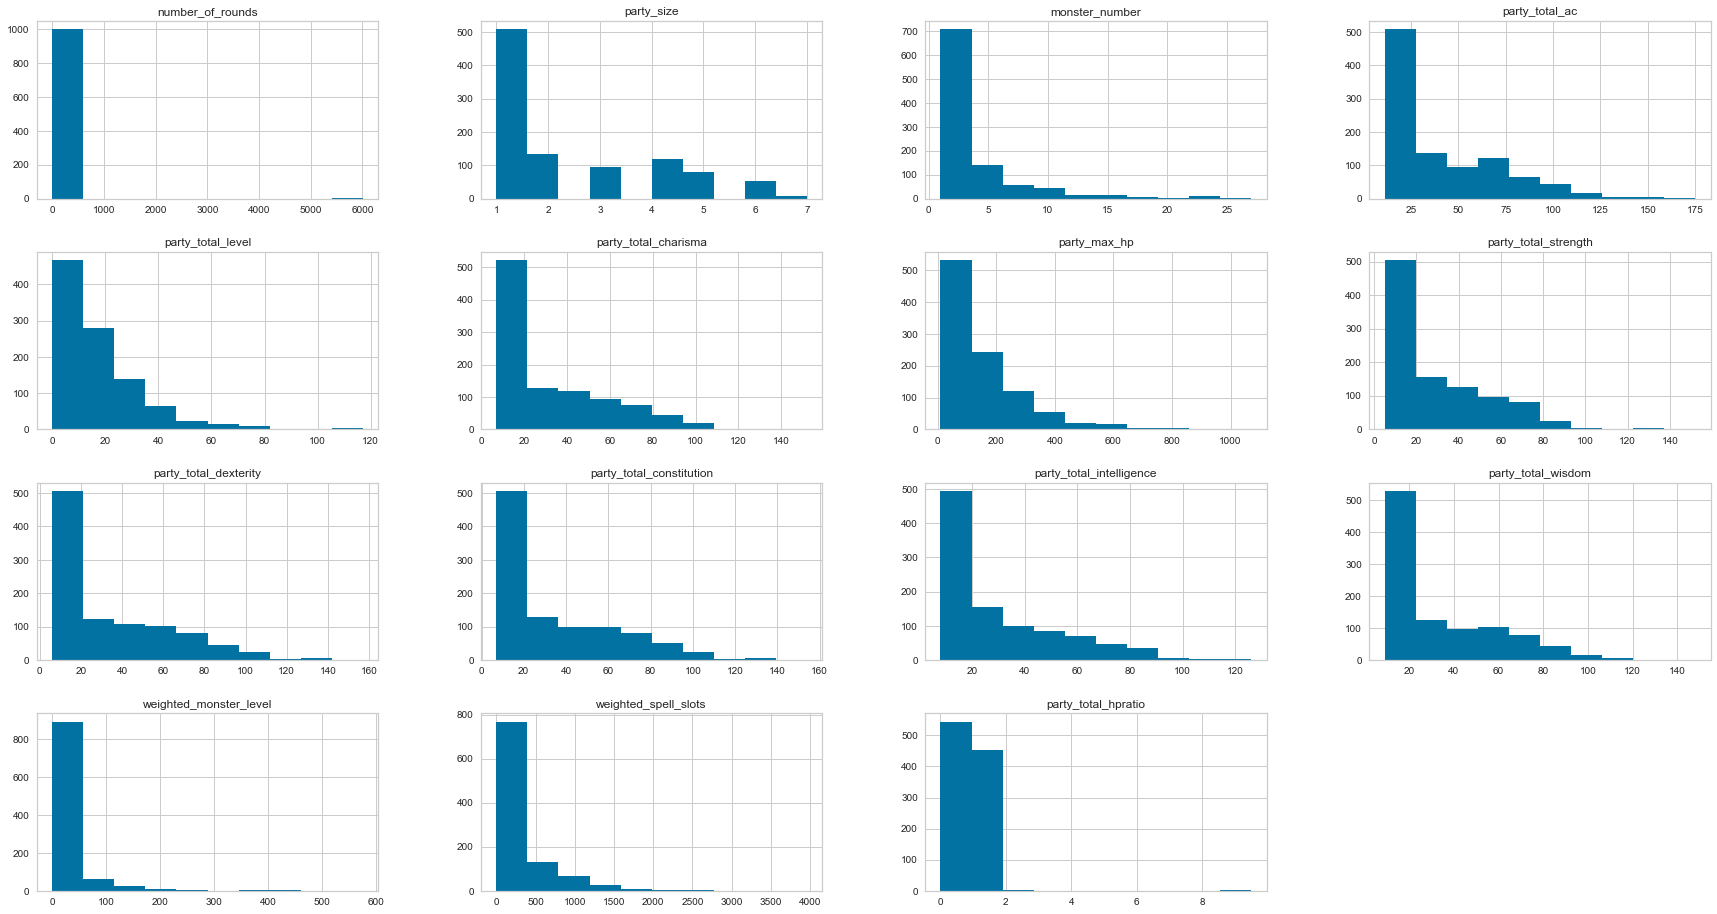

In [215]:
df.hist(figsize=(30, 16));

## CORRELATION

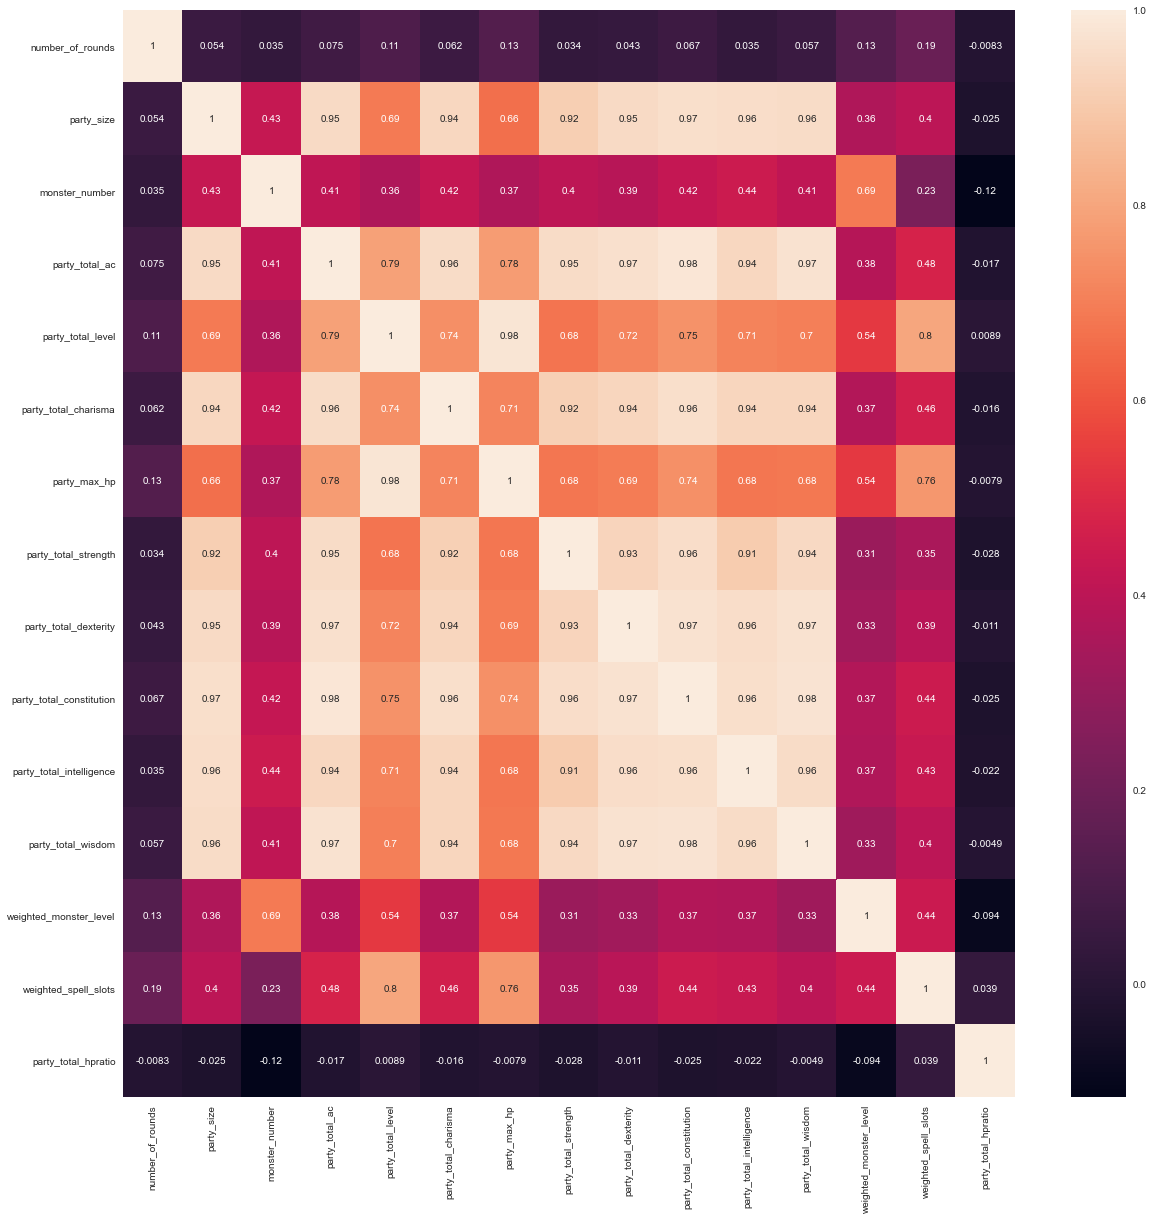

In [216]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)
plt.show()

## BASIC METRICS / STATS

In [217]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_rounds,1000.00,10.11,189.88,0.00,2.00,3.00,5.00,6007.00
party_size,1000.00,2.32,1.66,1.00,1.00,1.00,4.00,7.00
monster_number,1000.00,3.42,4.16,1.00,1.00,2.00,4.00,27.00
party_total_ac,1000.00,40.19,30.14,11.00,17.00,24.00,61.00,175.00
party_total_level,1000.00,17.74,15.86,0.00,7.00,13.00,24.00,117.00
party_total_charisma,1000.00,32.56,25.22,7.00,12.00,20.00,49.00,152.00
party_max_hp,1000.00,152.76,143.01,9.00,53.75,109.00,202.00,1070.00
party_total_strength,1000.00,30.11,23.53,5.00,11.00,19.00,47.00,152.00
party_total_dexterity,1000.00,35.90,26.65,6.00,16.00,20.00,54.00,157.00
party_total_constitution,1000.00,36.08,27.14,7.00,14.00,20.00,56.00,154.00


In [218]:
df.head(10)

,number_of_rounds,party_size,monster_number,party_total_ac,party_total_level,party_total_charisma,party_max_hp,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,weighted_monster_level,weighted_spell_slots,party_total_hpratio
0,1,1,1,17,10,11,65,14,16,12,12,14,4.00,139,1.00
1,2,1,3,14,5,13,38,14,16,14,10,13,5.00,12,0.00
2,4,2,1,31,17,23,154,27,30,31,23,36,4.00,367,1.07
3,6,2,5,31,18,23,154,27,30,31,23,36,12.00,449,0.87
4,2,4,1,155,58,106,524,127,137,126,83,118,1.00,871,0.99
5,2,4,7,155,58,106,524,127,137,126,83,118,5.00,871,1.00
6,8,5,3,71,16,61,141,46,73,74,66,69,9.00,110,0.76
7,5,3,3,46,9,42,82,31,49,45,32,34,1.50,18,0.76
8,2,4,5,155,58,106,524,127,137,126,83,118,40.00,839,0.88
9,7,2,1,38,29,22,332,27,34,36,25,38,4.00,24,0.67


## PYCARAT

In [219]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format 
from pycaret.regression import *

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number_of_rounds          1000 non-null   int64  
 1   party_size                1000 non-null   int64  
 2   monster_number            1000 non-null   int64  
 3   party_total_ac            1000 non-null   int64  
 4   party_total_level         1000 non-null   int64  
 5   party_total_charisma      1000 non-null   int64  
 6   party_max_hp              1000 non-null   int64  
 7   party_total_strength      1000 non-null   int64  
 8   party_total_dexterity     1000 non-null   int64  
 9   party_total_constitution  1000 non-null   int64  
 10  party_total_intelligence  1000 non-null   int64  
 11  party_total_wisdom        1000 non-null   int64  
 12  weighted_monster_level    1000 non-null   float64
 13  weighted_spell_slots      1000 non-null   int64  
 14  party_tot

In [221]:
df.head(1)

,number_of_rounds,party_size,monster_number,party_total_ac,party_total_level,party_total_charisma,party_max_hp,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,weighted_monster_level,weighted_spell_slots,party_total_hpratio
0,1,1,1,17,10,11,65,14,16,12,12,14,4.00,139,1.00


In [222]:
df.corr()['party_total_hpratio'].sort_values()

monster_number             -0.12
weighted_monster_level     -0.09
party_total_strength       -0.03
party_size                 -0.03
party_total_constitution   -0.03
party_total_intelligence   -0.02
party_total_ac             -0.02
party_total_charisma       -0.02
party_total_dexterity      -0.01
number_of_rounds           -0.01
party_max_hp               -0.01
party_total_wisdom         -0.00
party_total_level           0.01
weighted_spell_slots        0.04
party_total_hpratio         1.00
Name: party_total_hpratio, dtype: float64

In [223]:
# This is the setup function in Pycaret and is the first step you do. There are are ton of parameters you can use inside of it. 
# You can read about it here https:..


#//pycaret.readthedocs.io/en/stable/api/regression.html#

reg_setup= setup(data = df, target = 'party_total_hpratio', html = False)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
number_of_rounds,Numeric
party_size,Categorical
monster_number,Numeric
party_total_ac,Numeric
party_total_level,Numeric
party_total_charisma,Numeric
party_max_hp,Numeric
party_total_strength,Numeric
party_total_dexterity,Numeric
party_total_constitution,Numeric


Setup Succesfully Completed!


,Description,Value
0,session_id,5300
1,Target,party_total_hpratio
2,Original Data,"(1000, 15)"
3,Missing Values,False
4,Numeric Features,13
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(699, 20)"


In [74]:
# #The compare models function iteratively adds one model at a time and filters the best model to the top. If you scroll to the bottom, it looks like
# the best model it came up with was Orthogonal Matching Pursuit. If you only want to focus on one or a few metrics though, you can just see
# which one scored the best. FYI, this is a starting point, it actually doesn't build the model. We can do that in the next step.


best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69
par,Passive Aggressive Regressor,0.81,64.69,3.17,-944.20,0.35,1.36,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69
par,Passive Aggressive Regressor,0.81,64.69,3.17,-944.20,0.35,1.36,0.01
huber,Huber Regressor,0.80,207.45,4.85,-3031.89,0.25,1.32,0.03


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69
par,Passive Aggressive Regressor,0.81,64.69,3.17,-944.20,0.35,1.36,0.01
huber,Huber Regressor,0.80,207.45,4.85,-3031.89,0.25,1.32,0.03


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69
par,Passive Aggressive Regressor,0.81,64.69,3.17,-944.20,0.35,1.36,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01
lr,Linear Regression,0.83,52.78,4.65,-714.93,0.35,1.29,0.69


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01
omp,Orthogonal Matching Pursuit,0.44,33.72,2.09,-491.91,0.21,0.82,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ada,AdaBoost Regressor,0.23,0.08,0.29,-0.13,0.17,0.45,0.10
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01
ridge,Ridge Regression,0.44,33.39,2.08,-487.06,0.21,0.81,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ada,AdaBoost Regressor,0.23,0.08,0.29,-0.13,0.17,0.45,0.10
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01
br,Bayesian Ridge,0.38,19.01,1.62,-276.83,0.21,0.73,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ada,AdaBoost Regressor,0.23,0.08,0.29,-0.13,0.17,0.45,0.10
dt,Decision Tree Regressor,0.23,0.12,0.35,-0.72,0.22,0.51,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
lightgbm,Light Gradient Boosting Machine,0.18,0.06,0.25,0.13,0.16,0.41,1.46
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53
ada,AdaBoost Regressor,0.23,0.08,0.29,-0.13,0.17,0.45,0.10


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.17,0.06,0.24,0.24,0.15,0.39,1.37
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
lightgbm,Light Gradient Boosting Machine,0.18,0.06,0.25,0.13,0.16,0.41,1.46
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.17,0.06,0.24,0.24,0.15,0.39,1.37
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
lightgbm,Light Gradient Boosting Machine,0.18,0.06,0.25,0.13,0.16,0.41,1.46
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.17,0.06,0.24,0.24,0.15,0.39,1.37
rf,Random Forest Regressor,0.17,0.06,0.25,0.18,0.15,0.41,0.25
gbr,Gradient Boosting Regressor,0.18,0.06,0.25,0.18,0.15,0.43,0.14
lightgbm,Light Gradient Boosting Machine,0.18,0.06,0.25,0.13,0.16,0.41,1.46
et,Extra Trees Regressor,0.18,0.07,0.26,0.11,0.16,0.41,0.25
xgboost,Extreme Gradient Boosting,0.18,0.07,0.26,0.08,0.16,0.41,0.77
en,Elastic Net,0.22,0.08,0.27,-0.00,0.17,0.53,0.01
lasso,Lasso Regression,0.22,0.08,0.27,-0.00,0.17,0.53,0.02
knn,K Neighbors Regressor,0.20,0.08,0.28,-0.02,0.17,0.51,0.02
llar,Lasso Least Angle Regression,0.22,0.08,0.28,-0.03,0.17,0.54,0.53


In [224]:
# Since I am not familiar with Orthogonal Matching Pursuit, I am just going to use Gradient Boosting Regressor. 
# Build model here for Gradient Boosting Regressor. Use the model id to build whichever one you like (rf, lightgbm, gbr, etc..). Folds
# are the different cross-validation folds

catboost_model = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.20,0.11,0.34,-0.06,0.19,0.67
1,0.16,0.07,0.26,0.14,0.15,0.18
2,0.16,0.07,0.26,-0.41,0.14,0.23
3,0.18,0.07,0.27,-0.08,0.16,0.48
4,0.19,0.17,0.41,-1.49,0.20,0.53
5,0.19,0.08,0.28,0.17,0.17,0.58
6,0.19,0.08,0.27,0.24,0.18,0.87
7,0.25,0.14,0.37,-0.65,0.21,0.52
8,0.22,0.12,0.35,-0.35,0.21,0.65


In [225]:
# Tune the model here. This finds the best hyperparameters for the model. There is a parameter called n_iter
# setting this to 3 to speed up but you can play with that number

tuned_catboost_model = tune_model(catboost_model, n_iter = 10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.4s finished


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.20,0.10,0.32,0.04,0.18,0.92
1,0.19,0.07,0.27,0.05,0.16,0.22
2,0.17,0.04,0.20,0.15,0.12,0.25
3,0.18,0.06,0.25,0.11,0.15,0.52
4,0.18,0.06,0.25,0.09,0.16,0.39
5,0.21,0.09,0.29,0.08,0.19,0.75
6,0.21,0.09,0.30,0.09,0.20,1.04
7,0.22,0.08,0.29,0.04,0.18,0.48
8,0.21,0.08,0.28,0.10,0.19,0.56


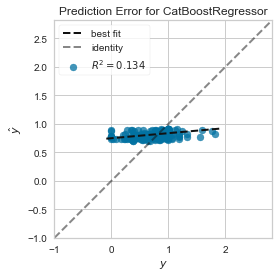

In [226]:
#Can visulize errors using this

plot_model(tuned_catboost_model, plot = 'error')

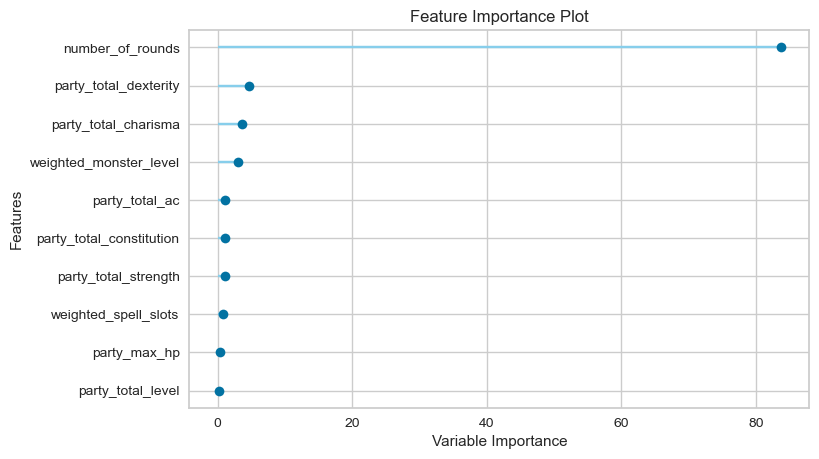

In [227]:
#Can visulize feature importance using this

plot_model(tuned_catboost_model, plot='feature')

## XgBoost

In [228]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [229]:
## import xgboost
import xgboost

In [230]:
df = df[['number_of_rounds',
         'party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

In [231]:
#df = df.select_dtypes(exclude=['object'])

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number_of_rounds          10842 non-null  int64  
 1   party_size                10842 non-null  int64  
 2   monster_number            10842 non-null  int64  
 3   party_total_ac            10842 non-null  int64  
 4   party_total_level         10842 non-null  int64  
 5   party_total_charisma      10842 non-null  int64  
 6   party_max_hp              10842 non-null  int64  
 7   party_total_strength      10842 non-null  int64  
 8   party_total_dexterity     10842 non-null  int64  
 9   party_total_constitution  10842 non-null  int64  
 10  party_total_intelligence  10842 non-null  int64  
 11  party_total_wisdom        10842 non-null  int64  
 12  weighted_monster_level    10842 non-null  float64
 13  weighted_spell_slots      10842 non-null  int64  
 14  party_

## Define X, y

In [233]:
y = df.pop('party_total_hpratio')
X = df

## Test Train Split

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Build XgBoost Regressor Model

In [235]:
df.head(1)

,number_of_rounds,party_size,monster_number,party_total_ac,party_total_level,party_total_charisma,party_max_hp,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,weighted_monster_level,weighted_spell_slots
0,1,1,1,17,10,11,65,14,16,12,12,14,4.00,139


In [236]:
import xgboost as xgb 

parameters = {#'nthread':[12], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.1], #so called `eta` value
              'max_depth': [7],
#              'min_child_weight': [1], # originally tried 4
#              'subsample': [0.7],
#              'colsample_bytree': [0.7],
              'n_estimators': [100]}

xgb = xgboost.XGBRegressor(n_estimators=1000, 
                   max_depth=20, 
                   eta=0.4, 
                   subsample=0.7, 
                   colsample_bytree=0.8)

xgb_gridsearch = GridSearchCV(xgboost.XGBRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

xgb_gridsearch.fit(X_train, y_train)

print( "best parameters:", xgb_gridsearch.best_params_ )

best_xgb_model = xgb_gridsearch.best_estimator_



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-10)]: Done   5 out of   5 | elapsed:    1.9s finished


best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [237]:
def score_model(best_xgb_model, X_train, y_train):
    MSE = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [238]:
print('xgb:', score_model(best_xgb_model, X_train, y_train))

xgb: (0.8805136856802399, -4.105977458676171)


In [240]:
def score_model(xgb, X_train, y_train):
    MSE = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [241]:
print('xgb:', score_model(xgb, X_train, y_train))

xgb: (0.6539986922773778, -1.5415026780377288)


In [243]:
mse = mean_squared_error(y_test, best_xgb_model.predict(X_test))
rmse = mean_squared_error(y_test, best_xgb_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_xgb_model.predict(X_test)) 

In [95]:
r2 = r2_score(y, f) 

In [244]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Mean Squared Error: 0.23618878153016848
Root Mean Squared Error: 0.4859925735339672
R-squared Score: 0.07451364592183318


In [299]:
#plot_model(best_xgb_model, plot='feature')

In [245]:
y_hat = best_xgb_model.predict(X_test)

In [246]:
def r2(y, y_hat):
    return 1-((y-y_hat)**2).sum()/((y-y.mean())**2).sum()
def rmse(y, y_hat):
    return (((y-y_hat)**2).sum()/y.shape[0])**0.5

In [247]:
r2(y_test, y_hat), sklearn.metrics.r2_score(y_test, y_hat)

(0.07451364592183318, 0.07451364592183318)

In [248]:
xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print( "best parameters:", xgb_gridsearch.best_params_ )

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   18.4s finished


best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
-0.242519750050239
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


## CatBoost 

In [337]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [338]:
df = df[['number_of_rounds',
         'party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

In [318]:
df['number_of_rounds'] = df['number_of_rounds'].astype(int)
df['party_size'] = df['party_size'].astype(int)
df['monster_number'] = df['monster_number'].astype(int)
df['party_total_ac'] = df['party_total_ac'].astype(int)
df['party_total_level'] = df['party_total_level'].astype(int)
df['party_total_charisma'] = df['party_total_charisma'].astype(int)
df['party_max_hp'] = df['party_max_hp'].astype(int)
df['party_total_strength'] = df['party_total_strength'].astype(int)
df['party_total_dexterity'] = df['party_total_dexterity'].astype(int)
df['party_total_constitution'] = df['party_total_constitution'].astype(int)
df['party_total_intelligence'] = df['party_total_intelligence'].astype(int)
df['party_total_wisdom'] = df['party_total_wisdom'].astype(int)
df['weighted_monster_level'] = df['weighted_monster_level'].astype(int)
df['weighted_spell_slots'] = df['weighted_spell_slots'].astype(int)
df['party_total_hpratio'] = df['party_total_hpratio'].astype(int)

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number_of_rounds          10842 non-null  int64  
 1   party_size                10842 non-null  int64  
 2   monster_number            10842 non-null  int64  
 3   party_total_ac            10842 non-null  int64  
 4   party_total_level         10842 non-null  int64  
 5   party_total_charisma      10842 non-null  int64  
 6   party_max_hp              10842 non-null  int64  
 7   party_total_strength      10842 non-null  int64  
 8   party_total_dexterity     10842 non-null  int64  
 9   party_total_constitution  10842 non-null  int64  
 10  party_total_intelligence  10842 non-null  int64  
 11  party_total_wisdom        10842 non-null  int64  
 12  weighted_monster_level    10842 non-null  float64
 13  weighted_spell_slots      10842 non-null  int64  
 14  party_

In [340]:
y = df.pop('party_total_hpratio')
X = df

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [343]:
from catboost import CatBoostClassifier, CatBoostRegressor

parameters = {'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
            #  'min_child_weight': [4],
                'silent': [1],
              'subsample': [0.7],
              #'colsample_bytree': [0.7],
              'n_estimators': [500]}

catb = catboost.CatBoostRegressor(n_estimators=1000, 
                   max_depth=20, 
                   eta=0.4, 
                   subsample=0.7, 
                   #colsample_bytree=0.8
                        )

catb_gridsearch = GridSearchCV(catboost.CatBoostRegressor(),
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

catb_grid.fit(X_train, y_train)

print( "best parameters:", catb_gridsearch.best_params_ )

best_catb_model = catb_gridsearch.best_estimator_

print(catb_grid.best_score_)
print(catb_grid.best_params_)

#########################################################



NameError: name 'catboost' is not defined

In [304]:
def score_model(best_catb_model, X_train, y_train):
    MSE = cross_val_score(best_catb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(best_catb_model, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [305]:
mse = mean_squared_error(y_test, best_catb_model.predict(X_test))
rmse = mean_squared_error(y_test, best_catb_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_catb_model.predict(X_test)) 

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 3 should be feature with name monster_total_level (found party_total_ac).

In [306]:
print("catb - Mean Squared Error:", mse)
print("catb - Root Mean Squared Error:", rmse)
print("catb - R-squared Score:", r2)

catb - Mean Squared Error: 0.23618878153016848
catb - Root Mean Squared Error: <function rmse at 0x7fca57fc6040>
catb - R-squared Score: <function r2 at 0x7fca57fc6310>


In [125]:
print('catb:', score_model(best_catb_model, X_train, y_train))

0:	learn: 0.7150664	total: 5.63ms	remaining: 557ms
1:	learn: 0.7107791	total: 8.49ms	remaining: 416ms
2:	learn: 0.7080392	total: 12.3ms	remaining: 398ms
3:	learn: 0.6980417	total: 16.4ms	remaining: 395ms
4:	learn: 0.6944273	total: 21.2ms	remaining: 404ms
5:	learn: 0.6837893	total: 25.9ms	remaining: 406ms
6:	learn: 0.6743407	total: 29.6ms	remaining: 393ms
7:	learn: 0.6714173	total: 32.9ms	remaining: 378ms
8:	learn: 0.6690149	total: 35.7ms	remaining: 361ms
9:	learn: 0.6570920	total: 38.6ms	remaining: 347ms
10:	learn: 0.6454640	total: 42.4ms	remaining: 343ms
11:	learn: 0.6437063	total: 45.8ms	remaining: 336ms
12:	learn: 0.6351359	total: 48.6ms	remaining: 325ms
13:	learn: 0.6329672	total: 51.1ms	remaining: 314ms
14:	learn: 0.6228080	total: 53.4ms	remaining: 303ms
15:	learn: 0.6211198	total: 56.3ms	remaining: 295ms
16:	learn: 0.6131562	total: 59.3ms	remaining: 289ms
17:	learn: 0.6031398	total: 61.6ms	remaining: 281ms
18:	learn: 0.6010872	total: 63.9ms	remaining: 272ms
19:	learn: 0.5927090	t

## AdaBoost

In [169]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [170]:
df = df[['number_of_rounds',
         'party_size',
         'monster_number',
         'monster_total_level',
         'party_total_level', 
         'party_level1_spellslots',
         'party_level2_spellslots', 
         'party_level3_spellslots',
         'party_level4_spellslots', 
         'party_level5_spellslots',
         'party_level6_spellslots', 
         'party_level7_spellslots',
         'party_level8_spellslots', 
         'party_level9_spellslots',
         'party_total_ac',
         'party_total_charisma',
         'player_monster_ratio', 
         'monster_player_ratio',
         'party_max_hp',
         'Druid',
         'party_total_strength', 
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'Cleric',
         'Wizard',
         'Rogue',
         'Warlock',
         'Sorcerer',
         'Blood Hunter',
         'Monk',
         'Bard',
         'Barbarian',
         'Fighter',
         'Paladin',
         'Ranger',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']] 

In [171]:
y = df.pop('party_total_hpratio')
X = df

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [206]:
dtr = DecisionTreeRegressor(max_depth=10)
abr = AdaBoostRegressor(base_estimator=dtr, n_estimators=100, learning_rate=0.1, loss='linear', random_state=42)

abr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=10,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                 

In [207]:
y_pred = abr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.24093203824285533


In [208]:
mse = mean_squared_error(y_test, abr.predict(X_test))
rmse = mean_squared_error(y_test, abr.predict(X_test)) ** 0.5
r2 = r2_score(y_test, abr.predict(X_test)) 

In [209]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Mean Squared Error: 0.24093203824285533
Root Mean Squared Error: 0.490848284343396
R-squared Score: 0.055927583819130655


In [198]:
ada = AdaBoostRegressor(
                        learning_rate=0.1,
                       # iterations=50,
              #          depth=10,
                        n_estimators=100,
            #            verbose=10,
           #             loss_function='RMSE',
                        random_state=1)

ada_gridsearch = GridSearchCV(AdaBoostRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

    
ada_gridsearch.fit(X_train, y_train)


print( "best parameters:", ada_gridsearch.best_params_ )

best_ada_model = ada_gridsearch.best_estimator_


NameError: name 'adaboost' is not defined

In [196]:
ada = AdaBoostRegressor()

ada_grid =      {'n_estimators':[500,1000,2000],
                 'learning_rate':[.001,0.01,.1],
                 'random_state':[1]}

grid_ADA = GridSearchCV((ada,
                         scoring='neg_mean_squared_error',
                         n_jobs=1,
                         cv=crossvalidation)
    
grid_ADA.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_ADA.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_ADA.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_ADA.best_params_)

best_ada_model = grid_ADA.best_estimator_

SyntaxError: invalid syntax (<ipython-input-196-eeaadf0f5309>, line 8)

In [151]:
ada = AdaBoostRegressor()

ada_grid =      {'n_estimators':[500,1000,2000],
                 'learning_rate':[.001,0.01,.1],
                 'random_state':[1]}

grid_ADA = GridSearchCV((ada,
                      #   scoring = 'neg_mean_squared_error',
                         n_jobs=1,
                         cv=crossvalidation)
    
grid_ADA.fit(X_train, y_train)
                        
best_ada_model = grid_ADA.best_estimator_
##################
ada = AdaBoostRegressor('n_estimators':[500,1000,2000],
                 'learning_rate':[.001,0.01,.1],
                 'random_state':[1])                        

ada_gridsearch = GridSearchCV(AdaBoostRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

ada_gridsearch.fit(X_train, y_train)
                        
print( "best parameters:", ada_gridsearch.best_params_ )

best_ada_model = ada_gridsearch.best_estimator_
                        
###################
                        
catb = CatBoostRegressor(
                        learning_rate=0.1,
                        iterations=50,
                        depth=10,
                        n_estimators=100,
                        verbose=10,
                        loss_function='RMSE',
                        random_state=1)

catb_gridsearch = GridSearchCV(CatBoostRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

catb_gridsearch.fit(X_train, y_train)

print( "best parameters:", catb_gridsearch.best_params_ )

best_catb_model = catb_gridsearch.best_estimator_

SyntaxError: invalid syntax (<ipython-input-151-8b2ac9ae2d01>, line 9)

In [ ]:
def score_model(best_ada_model, X_train, y_train):
    MSE = cross_val_score(best_ada_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(best_ada_model, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [ ]:
mse = mean_squared_error(y_test, best_ada_model.predict(X_test))
rmse = mean_squared_error(y_test, best_catb_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_catb_model.predict(X_test)) 

In [ ]:
print("adab - Mean Squared Error:", mse)
print("adab - Root Mean Squared Error:", rmse)
print("adab - R-squared Score:", r2)